 by article: every row
 by sentence: combine everything then split into sentence

In [ ]:
#train on nus sms
#use other camps data

In [2]:
import pandas as pd
import numpy as np
import nltk
import regex
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import itertools
from sklearn.cluster import KMeans
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline

In [3]:
#original review
cmpb = pd.read_csv('cmpb.csv')
cmpb = cmpb['Content']
#pre processing
cmpb.replace('', np.nan, inplace = True)
cmpb = cmpb.dropna()

In [4]:
cmpb

0     Very Professional People down there. Recommend...
1     Unlike what the other reviews may suggest, peo...
2     The place overall is fine. Good experience. Ju...
3     I went there for my NS Checkup today 29 August...
4     Don't bother showing up at the timing assigned...
5         just here to read through the NSF reviews LOL
6     Takes a extremely long time due to waiting. Ov...
7     All staff are professional and knows what they...
8     Unfriendly staff. The guards are doing their j...
9     staff at medical screening station 5 for heigh...
10    Staff were not serious; impatient. Undesirably...
11    Just sent my son for the pre enlistment checku...
12    One of the most inconvenient locations I have ...
13    Ok lah, this review is based on my visit Janua...
14    Tbh, its not that bad of a place to visit, con...
15    Those enlisting here, PLEASE make sure you dec...
16    Guards at gate very rude. Ask question they ig...
17    Overall great experience and medic was pro

In [5]:
#by article: every word in one cell
test = []
by_review_cmpb = []
for r in cmpb:
    #print('original')
    #print(r)
    #pre processing
    r = r.replace('\r\n', ' ')
    r = r.lower()
    separate = r.split('-')
    r = ''.join(separate)
    r = re.sub(r'[^a-z\s\t]', '', r)
    test.append(r)
    a = nltk.sent_tokenize(r)
    b = a[0].split(' ')
    by_review_cmpb.append(b)
    #print(a)
    #print(b)

In [6]:
by_sentence_cmpb = []
combined = '.'.join(cmpb)
sentences = combined.split('.')
for r in sentences:
    if r == '':
        continue
    else:
        r = r.replace('\r\n', ' ')
        r = r.lower()
        separate = r.split('-')
        r = ''.join(separate)
        r = re.sub(r'[^a-z\s\t]', '', r)
        a = nltk.sent_tokenize(r)
        b = a[0].split(' ')
        by_sentence_cmpb.append(b)
        #print(a)
        #print(b)

In [8]:
#word2vec for by sentence
model_sentence = Word2Vec(window = 10, sg = 1, hs = 0, negative = 10, # for negative sampling
                          alpha=0.03, min_alpha=0.0007,seed = 14)
model_sentence.build_vocab(by_sentence_cmpb, progress_per=200)
model_sentence.train(by_sentence_cmpb, total_examples = model_sentence.corpus_count, 
            epochs=10, report_delay=1)

(1038, 9700)

In [9]:
model_sentence.init_sims(replace=True)

In [10]:
print(model_sentence)

Word2Vec(vocab=41, size=100, alpha=0.03)


In [13]:
model_sentence.most_similar(positive=["medical"])

<ipython-input-13-03ac285c62a2>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_sentence.most_similar(positive=["medical"])


[('to', 0.8719109892845154),
 ('experience', 0.863020658493042),
 ('the', 0.8626408576965332),
 ('there', 0.8546510934829712),
 ('is', 0.8537328243255615),
 ('place', 0.8517358303070068),
 ('this', 0.8426485061645508),
 ('here', 0.8426223993301392),
 ('a', 0.8406622409820557),
 ('my', 0.8403588533401489)]

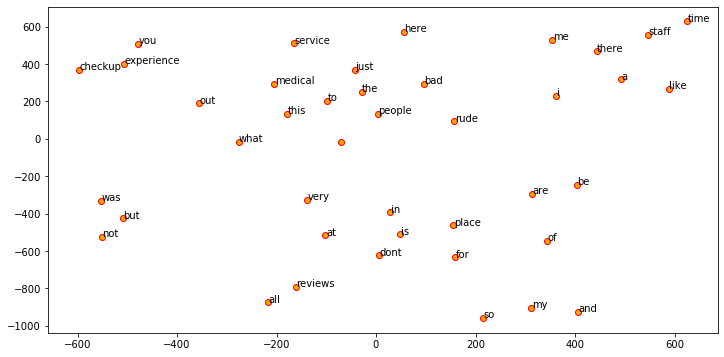

In [75]:
words = model_sentence.wv.index2word
wvs = model_sentence.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [40]:
#word2vec for by review
model_review = Word2Vec(window = 2, sg = 1, hs = 0, negative = 10, # for negative sampling
                          alpha=0.03, min_alpha=0.0007,seed = 14)
model_review.build_vocab(by_review_cmpb, progress_per=200,sample = 1e-3 )
model_review.train(by_review_cmpb, total_examples = model_review.corpus_count, 
            epochs=10, report_delay=1)

(969, 9240)

In [41]:
model_review.init_sims(replace=True)

In [42]:
print(model_review)

Word2Vec(vocab=41, size=100, alpha=0.03)


In [43]:
model_review.most_similar(positive=["medical"])

<ipython-input-43-8028d2d70302>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_review.most_similar(positive=["medical"])


[('the', 0.8138085007667542),
 ('to', 0.8002111315727234),
 ('and', 0.7747681736946106),
 ('are', 0.7621898055076599),
 ('out', 0.761546790599823),
 ('', 0.7584236264228821),
 ('here', 0.7539170384407043),
 ('staff', 0.752115786075592),
 ('this', 0.7489237189292908),
 ('is', 0.746063768863678)]

In [49]:
similar_words = {search_term: [item[0] for item in model_review.wv.most_similar([search_term], topn=5)]
                  for search_term in ['medical', 'staff', 'checkup', 'people', 'time']}
similar_words

{'medical': ['the', 'to', 'and', 'are', 'out'],
 'staff': ['', 'the', 'there', 'and', 'to'],
 'checkup': ['the', 'to', 'is', '', 'you'],
 'people': ['the', '', 'to', 'of', 'are'],
 'time': ['staff', 'are', 'and', 'my', 'there']}

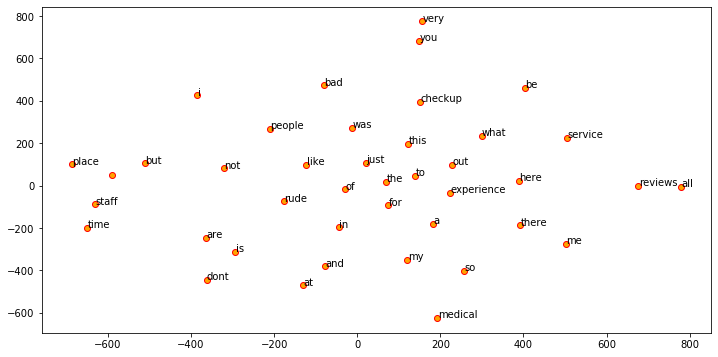

In [74]:
words = model_review.wv.index2word
wvs = model_review.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [64]:
df_new = pd.read_csv('bout.csv')

In [65]:
df_new = df_new.fillna('')
df_new = pd.Series([' '.join(row.astype(str)) for row in df_new.values], index=df_new.index)

In [66]:
new_list = []
for row in df_new:
    a = nltk.sent_tokenize(row)
    b = a[0].split(' ')
    new_list.append(b)
    #print(new_list)

In [67]:
model_bout = Word2Vec(window = 2, sg = 1, hs = 0, negative = 10, # for negative sampling
                          alpha=0.03, min_alpha=0.0007,seed = 14)
model_bout.build_vocab(new_list, progress_per=200,sample = 1e-3 )
model_bout.train(new_list, total_examples = model_bout.corpus_count, 
            epochs=10, report_delay=1)

(203, 7000)

In [68]:
model_bout.init_sims(replace=True)

In [69]:
print(model_bout)

Word2Vec(vocab=19, size=100, alpha=0.03)


In [70]:
model_bout.most_similar(positive=["medical"])

<ipython-input-70-5505e8cb01f7>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model_bout.most_similar(positive=["medical"])


[('staff', 0.17480576038360596),
 ('not', 0.13471922278404236),
 ('conditions', 0.09387607127428055),
 ('so', 0.09087174385786057),
 ('experience', 0.08840455114841461),
 ('rude', 0.05067929998040199),
 ('waste', 0.032695867121219635),
 ('bad', 0.03118954785168171),
 ('place', 0.020712140947580338),
 ('nsf', 0.012757696211338043)]

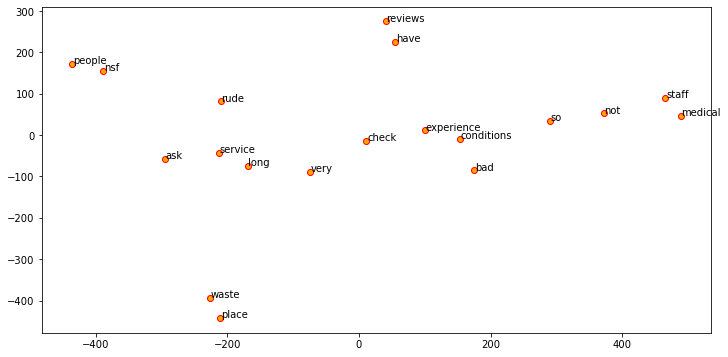

In [73]:
words = model_bout.wv.index2word
wvs = model_bout.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

In [71]:
similar_words = {search_term: [item[0] for item in model_bout.wv.most_similar([search_term], topn=5)]
                  for search_term in ['medical', 'staff', 'rude', 'people', 'nsf']}
similar_words

{'medical': ['staff', 'not', 'conditions', 'so', 'experience'],
 'staff': ['medical', 'not', 'experience', 'reviews', 'place'],
 'rude': ['service', 'bad', 'nsf', 'reviews', 'so'],
 'people': ['nsf', 'very', 'so', 'have', 'ask'],
 'nsf': ['people', 'long', 'rude', 'bad', 'so']}

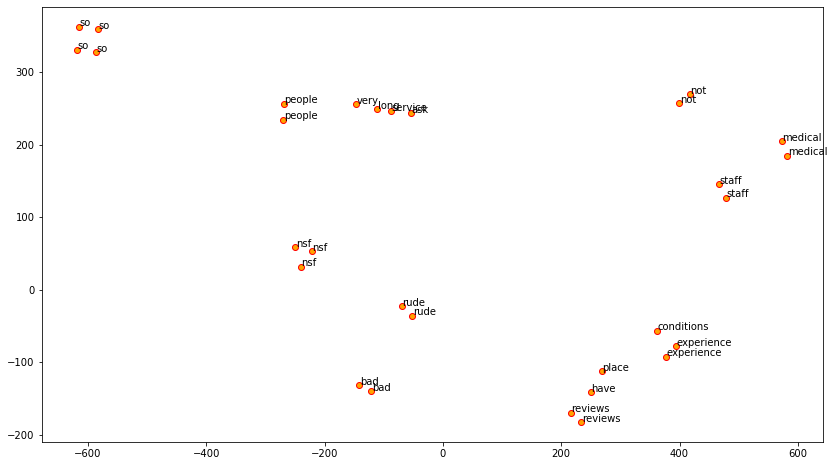

In [72]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model_bout.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [30]:
finalfeatures = pd.read_csv('finalFeatures.csv')
finalfeatures = finalfeatures[['index','Descriptors']]
#finalfeatures

In [35]:
ff = pd.Series([' '.join(row.astype(str)) for row in finalfeatures.values], index=finalfeatures.index)
for f in ff:
    print(f)
    f = f.replace(',','')
    print(f)
ff

#wpt = nltk.WordPunctTokenizer()
#tokenized_corpus = [wpt.tokenize(document) for document in ff]
#tokenized_corpus

staff professional ,unfriendly ,keep ,rude ,impatient ,rude ,nsf ,ok ,nice ,friendly ,rude
staff professional unfriendly keep rude impatient rude nsf ok nice friendly rude
people professional ,there ,suggest ,here ,threatens ,threatens ,kind ,help ,many ,give ,go ,kept
people professional there suggest here threatens threatens kind help many give go kept
medical checkup ,checkup ,screening ,conditions ,officer ,specialistletter ,check ,check ,check
medical checkup checkup screening conditions officer specialistletter check check check
bad reviews ,not ,that ,canteenb ,real ,canteenb ,real ,very ,troopers ,very ,attitude ,very ,troopers ,very ,attitude ,service ,service
bad reviews not that canteenb real canteenb real very troopers very attitude very troopers very attitude service service
place clean ,fine ,waste ,check
place clean fine waste check
rude staff ,extremely ,staff ,guards ,very ,staff ,unbelievably
rude staff extremely staff guards very staff unbelievably
time long ,takes ,

0     staff professional ,unfriendly ,keep ,rude ,im...
1     people professional ,there ,suggest ,here ,thr...
2     medical checkup ,checkup ,screening ,condition...
3     bad reviews ,not ,that ,canteenb ,real ,cantee...
4                       place clean ,fine ,waste ,check
5     rude staff ,extremely ,staff ,guards ,very ,st...
6                      time long ,takes ,travel ,travel
7     reviews other ,suggest ,nsf ,negative ,negativ...
8                          service dk ,public ,bad ,bad
9                        nsf reviews ,staff ,need ,cool
10                 overall fine ,waste ,experience ,had
11    experience good ,overall ,great ,definitely ,m...
12          really clean ,care ,have ,care ,have ,bored
13                          complete rest ,waste ,waste
14              professional very ,people ,staff ,medic
15                                 person last ,realise
16                           extremely long ,rude ,poor
17                               unfriendly staf

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

In [ ]:
tokenizer = dict()     

In [10]:
df_by_sentence_cmpb = pd.DataFrame(by_sentence_cmpb)
df_by_sentence_cmpb

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,very,professional,people,down,there,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,,recommended,very,patient,kind,respectful,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,,very,smooth,throughout,the,medical,checkup,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,unlike,what,the,other,reviews,may,suggest,people,here,were,...,None,None,None,None,None,None,None,None,None,None
4,,the,place,is,really,clean,and,efficient,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,interestingly,enough,all,the,negative,reviews,were,removed,None,None,...,None,None,None,None,None,None,None,None,None,None
94,bad,service,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
95,so,sheat,treated,like,dirty,pigs,training,to,step,on,...,None,None,None,None,None,None,None,None,None,None
96,gnc,present,here,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [2]:
testdf = pd.DataFrame(test, columns = ['content'])
testdf

NameError: name 'pd' is not defined

In [1]:
tokenizer = dict()
testdf['content'] = testdf['content'].apply(
    lambda content: [tokenizer.setdefault(named_entitie, len(tokenizer))
                            for named_entitie in content.split(' ')])
testdf.head()

NameError: name 'testdf' is not defined

In [ ]:
pairs_df = testdf['content'].apply(lambda named_entities: list(itertools.combinations(named_entities, 2)))
pairs_df = pairs_df[pairs_df.apply(len) > 0]
pairs_df = pd.DataFrame(np.concatenate(pairs_df.values), columns=['named_entity_1', 'named_entity_2'])
pairs_df.head()

In [ ]:
NAMED_ENTITIES_CO_OCCURENCE_THRESHOLD = 5

edges_df = pairs_df.groupby(['named_entity_1', 'named_entity_2']).size().reset_index(name='weight')
edges_df = edges_df[edges_df['weight'] > NAMED_ENTITIES_CO_OCCURENCE_THRESHOLD]
edges_df[['named_entity_1', 'named_entity_2', 'weight']].to_csv('edges.csv', header=False, index=False, sep=' ')
edges_df.head()

In [ ]:
nodes = pd.DataFrame(list(tokenizer.items()), columns = ['word','number'])
nodes

In [ ]:
edges_df.to_csv('edges.csv')
nodes.to_csv('nodes.csv')

In [ ]:
model = Word2Vec(min_count = 5, window = 5, hs = 0,
                 negative = 20, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

In [ ]:
model.build_vocab(new_list, progress_per=500)

In [ ]:
model.train(new_list, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

In [ ]:
model.init_sims(replace=True)

In [ ]:
print(model)

In [ ]:
X = model[model.wv.vocab]

X.shape

In [ ]:
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
model.most_similar(positive=["medical"])

In [ ]:
model.most_similar(positive=["staff"])

In [ ]:
model2 = Word2Vec(min_count = 5, window = 5, hs = 0,
                 negative = 20, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

In [ ]:
df_new

In [ ]:
test_df = pd.DataFrame(df_new, columns = ['content'])
test_df

In [ ]:
test_df['content'][0]